In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Set the display options
pd.set_option('display.max_rows', None)  # Unrestricted number of rows
pd.set_option('display.max_columns', None)  # Unrestricted number of columns
pd.set_option('display.width', None)  # Use maximum screen width
pd.set_option('display.max_colwidth', None)  # Unrestricted column width

compute_radars = True
compute_close_graphs = True
show_cluster_metrics = False

# normalisation
def normalize_data(df):
    df["weight"] = (df['weight'] - df['weight'].min()) / (df['weight'].max() - df['weight'].min())
    df["recovery"] = (df['recovery'] - df['recovery'].min()) / (df['recovery'].max() - df['recovery'].min())
    df["speed"] = (df['speed'] - df['speed'].min()) / (df['speed'].max() - df['speed'].min())
    df["combo_game"] = (df['combo_game'] - df['combo_game'].min()) / (df['combo_game'].max() - df['combo_game'].min())
    df["projectiles"] = (df['projectiles'] - df['projectiles'].min()) / (df['projectiles'].max() - df['projectiles'].min())
    df["killpower"] = 1 - ((df['killpower'] - df['killpower'].min()) / (df['killpower'].max() - df['killpower'].min()))
    df["ledgetrap"] = (df['ledgetrap'] - df['ledgetrap'].min()) / (df['ledgetrap'].max() - df['ledgetrap'].min())
    df["edgeguard"] = (df['edgeguard'] - df['edgeguard'].min()) / (df['edgeguard'].max() - df['edgeguard'].min())
    df["spacing"] = (df['spacing'] - df['spacing'].min()) / (df['spacing'].max() - df['spacing'].min())
    df["cheese"] = (df['cheese'] - df['cheese'].min()) / (df['cheese'].max() - df['cheese'].min())
    df["popularity"] = (df['popularity'] - df['popularity'].min()) / (df['popularity'].max() - df['popularity'].min())
    df["pro_scene"] = (df['pro_scene'] - df['pro_scene'].min()) / (df['pro_scene'].max() - df['pro_scene'].min())
    df["online_winrate"] = (df['online_winrate'] - df['online_winrate'].min()) / (df['online_winrate'].max() - df['online_winrate'].min())
    df["easy"] = 1 - ((df['easy'] - df['easy'].min()) / (df['easy'].max() - df['easy'].min()))
    return df

def read_data(file='smash.csv'):
    df = pd.read_csv(file, sep=',')
    df['name'] = df['name'].str.strip()
    df = df.set_index('name')
    df = df.drop(columns="id")
    df = df.replace({'': 0, ' x': 0, 'x': 0, 'x ': 0, np.nan: 0, ' ':0, '  ':0})
    for column in ['weight', 'recovery', 'speed', 'combo_game', 'projectiles', 'killpower', 'ledgetrap', 'edgeguard', 'spacing', 'cheese', 'easy', 'popularity', 'pro_scene', 'online_winrate']:
        df[column] = pd.to_numeric(df[column], errors='coerce')
    return df

def drop_columns(df, columns):
    """Drop specified columns from DataFrame."""
    return df.drop(columns=columns)


df = read_data()
df = normalize_data(df)
columns_order = ['weight', 'recovery', 'spacing', 'projectiles', 'speed', 'combo_game', 'killpower', 'edgeguard', 'ledgetrap', 'cheese', 'easy', 'popularity', 'pro_scene', 'online_winrate']
df = df[columns_order]
df.head()

,weight,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,popularity,pro_scene,online_winrate
name,,,,,,,,,,,,,,
Mario,0.493151,0.375,0.00,0.25,0.500,0.538462,0.470588,0.277778,0.300,0.333333,0.827842,0.386534,0.7,0.446222
Donkey Kong,0.890411,0.125,0.75,0.00,0.625,0.500000,0.862745,0.259259,0.425,0.555556,0.876340,0.391521,0.2,0.620889
Link,0.575342,0.500,0.75,1.00,0.375,0.192308,0.568627,0.240741,0.525,0.222222,0.482454,0.349127,0.4,0.482222
Samus,0.630137,0.625,0.25,1.00,0.375,0.115385,0.274510,0.407407,0.675,0.333333,0.722526,0.498753,0.7,0.612444
Yoshi,0.575342,0.750,0.25,0.25,0.625,0.346154,0.568627,0.314815,0.275,0.444444,0.798536,0.433915,0.7,0.580889


In [2]:
def plot_character_vs_median(df, character_name):
    try:
        # Get data for specific character
        character_data = df.loc[character_name].tolist() + [df.loc[character_name].tolist()[0]]

        # Calculate the median data
        median_data = df.median().tolist() + [df.median().tolist()[0]]

        # Compute angle for each axis
        num_vars = len(df.columns)
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist() + [0]

        fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
        # Plot for specific character
        ax.fill(angles, character_data, color='red', alpha=0.25)
        ax.plot(angles, character_data, color='red', label=character_name)
        # Plot for median
        ax.fill(angles, median_data, color='green', alpha=0.25)
        ax.plot(angles, median_data, color='green', label='Median')

        # Set the range of the radar
        ax.set_ylim(0, 1)

        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(df.columns, fontsize=13)
        ax.set_yticklabels([])
        ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.2))
        
        # Save the plot as an image file
        plt.title(f"{character_name} vs Median", size=20)
        plt.savefig(f"character_radars/{character_name}_vs_median.png")  # Save the figure to a file
        plt.close(fig)  # Close the figure to free up memory

    except KeyError:
        print(f"Character '{character_name}' not found in the DataFrame. Please check the character name and try again.")

# Plot and save radar charts for each character
if compute_radars:
    for character_name in df.index:
        plot_character_vs_median(df, character_name)

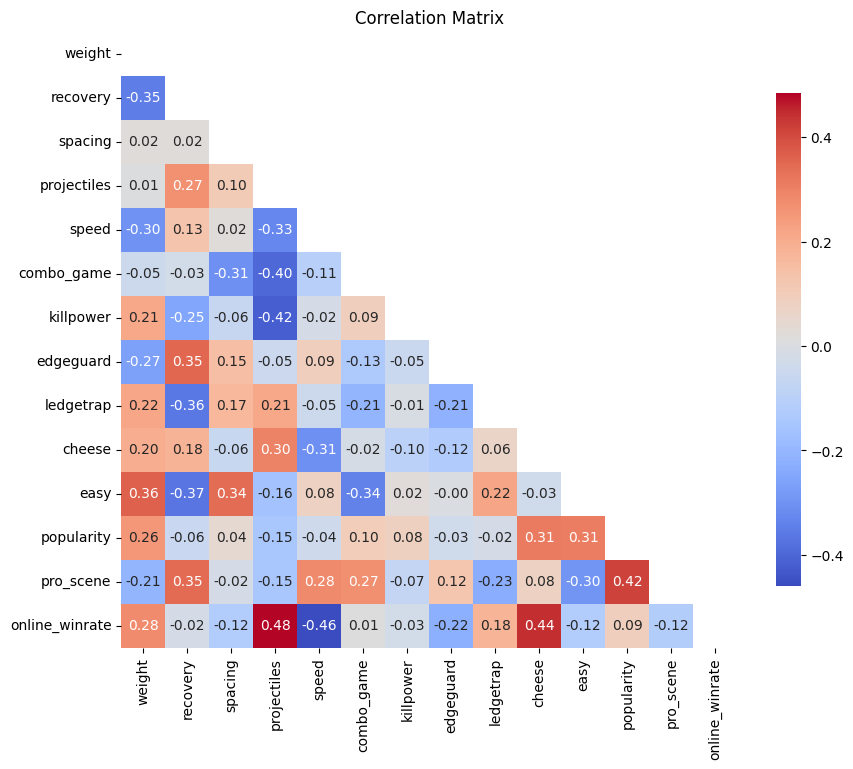

In [3]:
def show_correlations(df):
    correlation_matrix = df.corr()

    # Create a mask to hide the upper triangle of the correlation matrix
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

    plt.figure(figsize=(10, 8))
    # Plot the heatmap with the mask and correct aspect ratio
    sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
    plt.title('Correlation Matrix')
    plt.savefig("results/correlation_matrix.png", dpi=300, bbox_inches='tight')
    plt.show()
    
show_correlations(df)

In [4]:
def calculate_clustering_metrics(df, k_range):
    """Calculate KMeans clustering metrics over a range of k values."""
    sse = []
    silhouette_scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        clusters = kmeans.fit_predict(df)
        sse.append(kmeans.inertia_)
        silhouette = silhouette_score(df, clusters)
        silhouette_scores.append(silhouette)
    return sse, silhouette_scores

def plot_metrics(k_range, sse, silhouette_scores):
    """Plot SSE and Silhouette Scores to help determine the optimal number of clusters."""
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, sse, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Sum of Squared Distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(k_range, silhouette_scores, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Scores For Different k')
    plt.show()

def perform_clustering(df, n_clusters):
    """Perform KMeans clustering and add cluster assignments back to DataFrame."""
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(df)
    df['Cluster'] = clusters
    return df

def print_clusters(df):
    """Print each cluster and its characters."""
    cluster_groups = df.groupby('Cluster')['Cluster'].apply(lambda x: list(x.index))
    for cluster, characters in cluster_groups.items():
        print(f"Cluster {cluster}: {', '.join(characters)}")
        print()

columns_dropped_for_clustering = ['pro_scene', 'online_winrate', 'popularity']
df_clusters = df.drop(columns=columns_dropped_for_clustering).copy()

# KNN Clustering
if show_cluster_metrics:
    k_range = range(2, 15)
    sse, silhouette_scores = calculate_clustering_metrics(df_clusters, k_range)
    plot_metrics(k_range, sse, silhouette_scores)

n_clusters = 8
df_clusters = perform_clustering(df_clusters, n_clusters)
display(df_clusters.head())
print_clusters(df_clusters)

,weight,recovery,spacing,projectiles,speed,combo_game,killpower,edgeguard,ledgetrap,cheese,easy,Cluster
name,,,,,,,,,,,,
Mario,0.493151,0.375,0.00,0.25,0.500,0.538462,0.470588,0.277778,0.300,0.333333,0.827842,7
Donkey Kong,0.890411,0.125,0.75,0.00,0.625,0.500000,0.862745,0.259259,0.425,0.555556,0.876340,4
Link,0.575342,0.500,0.75,1.00,0.375,0.192308,0.568627,0.240741,0.525,0.222222,0.482454,2
Samus,0.630137,0.625,0.25,1.00,0.375,0.115385,0.274510,0.407407,0.675,0.333333,0.722526,2
Yoshi,0.575342,0.750,0.25,0.25,0.625,0.346154,0.568627,0.314815,0.275,0.444444,0.798536,7


Cluster 0: Sheik, Meta Knight, Zero Suit Samus, Wario, Pokemon Trainer, Sonic, Inkling

Cluster 1: Mewtwo, Mr. Game & Watch, R.O.B., Mii Swordfighter, Shulk, Joker, Hero, Sephiroth, Pyra Mythra, Sora

Cluster 2: Link, Samus, Ness, Zelda, Young Link, Lucas, King Dedede, Olimar, Toon Link, Villager, Rosalina & Luma, Mii Gunner, Robin, Bowser Jr., Duck Hunt, Simon, King K. Rool, Isabelle, Piranha Plant, Banjo & Kazooie, Min Min

Cluster 3: Luigi, Ice Climbers, Ryu, Ken, Terry, Kazuya

Cluster 4: Donkey Kong, Bowser, Ganondorf, Little Mac, Incineroar

Cluster 5: Pikachu, Peach, Pichu, Snake, Diddy Kong, Lucario, Megaman, Wii Fit Trainer, Pac-Man, Bayonetta, Steve

Cluster 6: Lucina, Marth, Roy, Chrom, Pit, Ike, Greninja, Cloud, Corrin, Byleth

Cluster 7: Mario, Yoshi, Kirby, Fox, Captain Falcon, Jigglypuff, Dr. Mario, Falco, Wolf, Mii Brawler, Palutena, Ridley



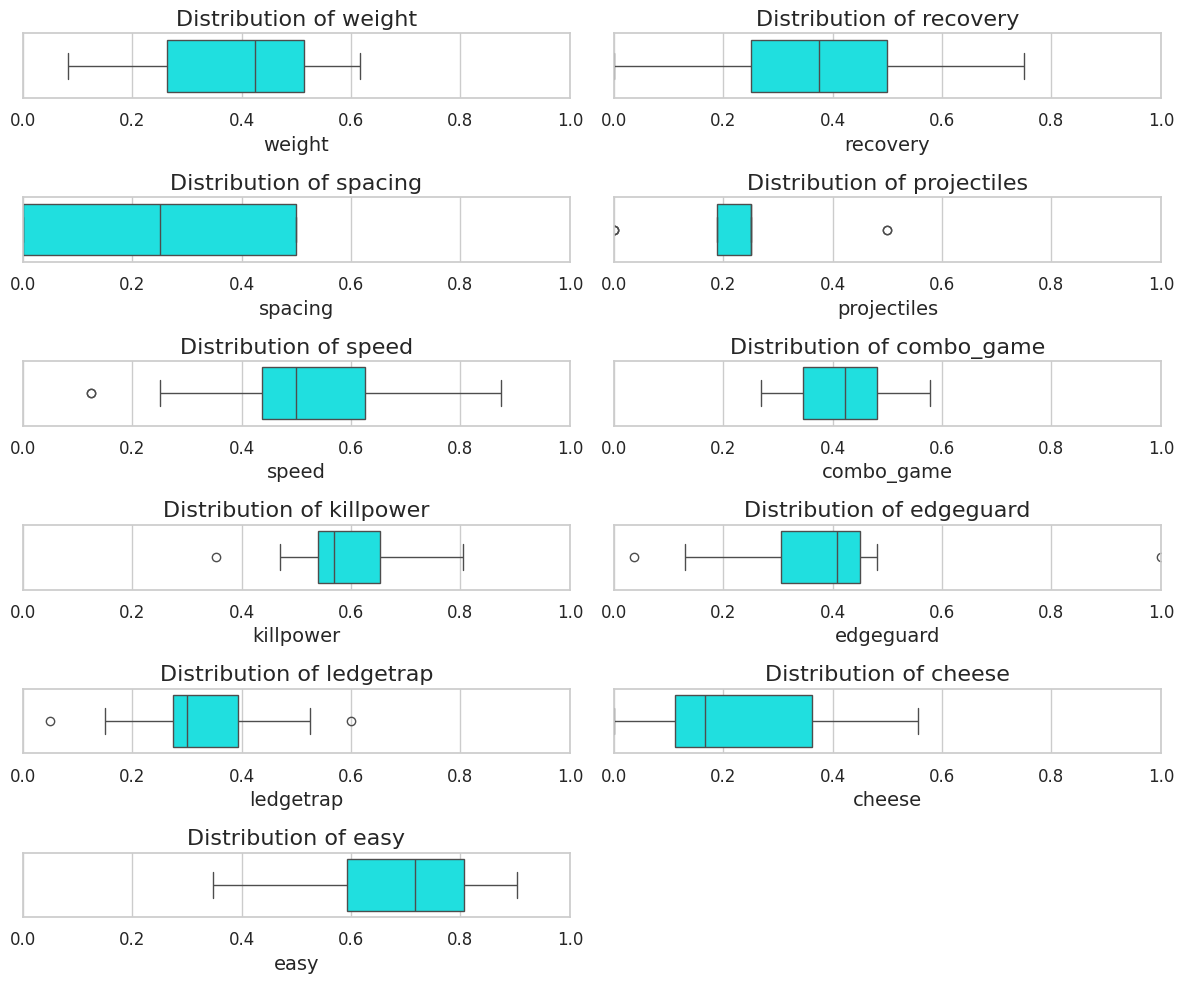

In [14]:
def visualize_cluster_attributes(df, cluster_number):
    # Assuming 'Cluster' is the column with cluster labels and 'cluster_number' is the cluster you want to visualize
    cluster_data = df[df['Cluster'] == cluster_number]

    # Set the aesthetic style of the plots
    sns.set(style="whitegrid")

    # Set up the matplotlib figure
    plt.figure(figsize=(12, 10))

    # Select only numerical columns and exclude the 'Cluster' column specifically
    num_columns = cluster_data.select_dtypes(include=[np.number]).columns.tolist()
    num_columns.remove('Cluster')  # Remove the 'Cluster' column from the list

    # Plotting multiple boxplots horizontally
    for i, column in enumerate(num_columns, 1):
        plt.subplot((len(num_columns) + 1) // 2, 2, i)  # Adjust the layout based on the number of plots
        sns.boxplot(x=cluster_data[column], color='cyan', orient='h')  # Set orient to 'h' for horizontal orientation
        plt.title(f'Distribution of {column}', fontsize=16)
        plt.xlabel(f'{column}', fontsize=14)
        plt.xticks(fontsize=12)
        plt.xlim(0, 1)  # Set the x-axis limits to be from 0 to 1

    # Adjust layout
    plt.tight_layout()
    plt.savefig(f"results/cluster_{cluster_number}_description.png", dpi=300, bbox_inches='tight')
    plt.show()
    
visualize_cluster_attributes(df_clusters, 7)

# 0 : très très bonne recovery, plutôt léger, corps à corps, assez rapide, edgeguard > ledgetrap                    Ninjas
# 1 : assez léger, spaceur, pas de combo                                                                            Strike Dancers (Poke and Flee)      
# 2 : spam projectiles, pas de combo, moyen ailleurs                                                                Marksmen
# 3 : recovery pas terrible, lent, combo de ouf, 0 edgeguard, difficile à jouer                                     Executioners
# 4 : très lourd, recovery naze, pas de projectile, combo pas terrible, très facile à jouer, un peu cheesy          Juggernauts
# 5 : bonne recovery, corps à corps, toujours projectile, un peu cheesy, pas facile à jouer                         Tacticians
# 6 : très bon spacing, peu de projectile, très honnête, facile à jouer                                             Blade Knights
# 7 : corps à corps, moyens partout                                                                                 All Rounders

/home/g.touati/.pyenv/versions/3.11.8/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


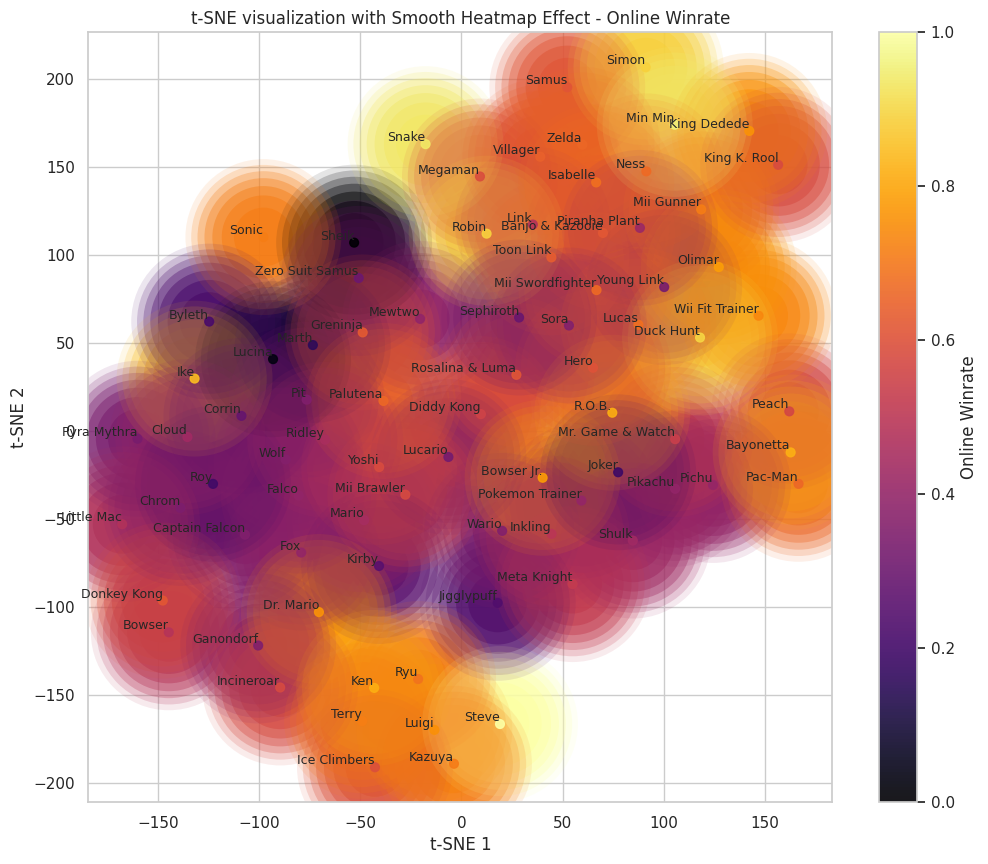

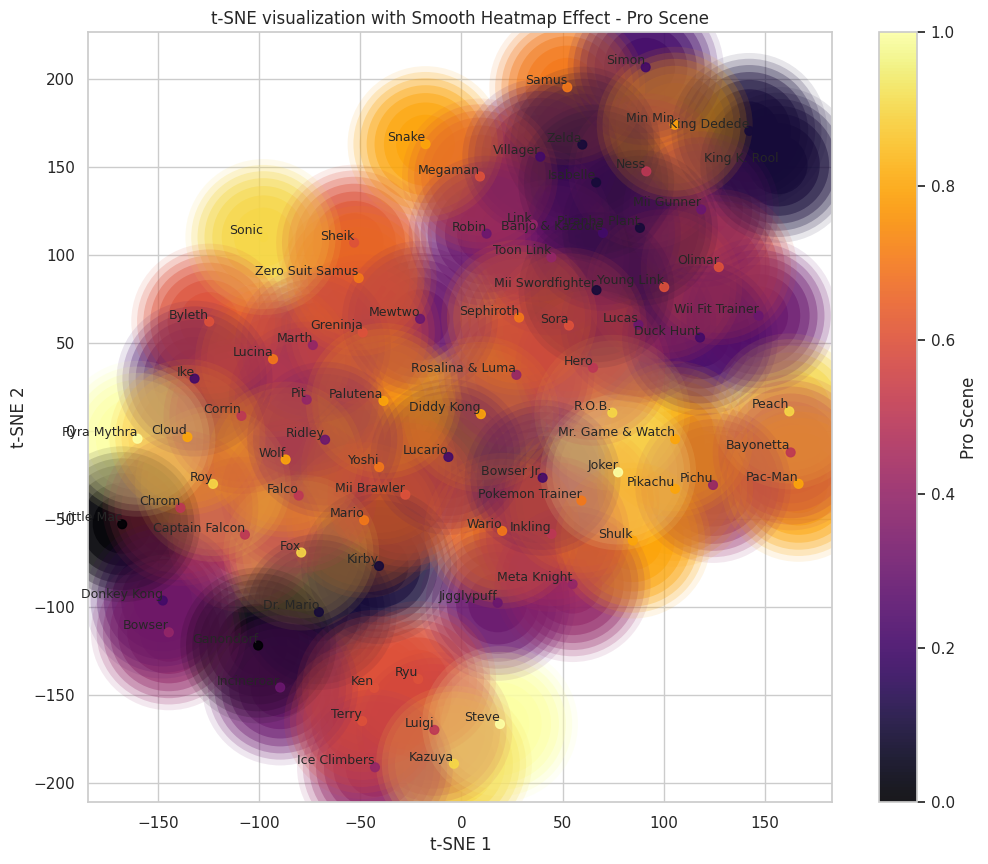

In [6]:
def prepare_data(df, columns_to_drop):
    """Standardize the data excluding the specified columns. Works on a copy to keep original DataFrame intact."""
    df_copy = df.copy()  # Create a copy of the DataFrame to keep original DataFrame unchanged
    df_copy.index.name = 'name'
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(df_copy.drop(columns_to_drop, axis=1))
    return data_scaled

def compute_tsne(data_scaled, n_components=2, perplexity=17, learning_rate=200, n_iter=10000, random_state=42):
    """Compute t-SNE embedding of the dataset."""
    tsne = TSNE(n_components=n_components, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter, random_state=random_state)
    tsne_results = tsne.fit_transform(data_scaled)
    return tsne_results

def plot_tsne_heatmap(tsne_results, labels, names, label_name, glow_size_factor=1.0, title='t-SNE Heatmap Visualization'):
    """Plot t-SNE results with smooth color erosion."""
    cmap = plt.cm.inferno  # High-contrast colormap
    norm = Normalize(vmin=min(labels), vmax=max(labels))  # Normalize color scale

    plt.figure(figsize=(12, 10))
    # Fine-tuned glow effect
    num_layers = 7  # Increased number of layers for smoother gradient
    base_size = 20  # Starting size for the smallest layer
    alpha_values = np.linspace(0.6, 0.1, num_layers)  # Linear space for alpha values
    sizes = [base_size * (i + 1) * glow_size_factor for i in range(num_layers)]  # Incremental sizes

    for size, alpha in zip(sizes, alpha_values):
        plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=size, c=labels, cmap=cmap, norm=norm, alpha=alpha, edgecolor='none')

    # Main scatter plot for the actual points with labels
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=40, c=labels, cmap=cmap, norm=norm, alpha=0.9)

    # Adding labels to each point
    for i, txt in enumerate(names):
        plt.annotate(txt, (tsne_results[i, 0], tsne_results[i, 1]), fontsize=9, ha='right', va='bottom')

    plt.colorbar(scatter, label=label_name)
    plt.title(title)
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.show()

# Example usage
columns_to_drop = ['Cluster']
data_scaled = prepare_data(df_clusters, columns_to_drop)
tsne_results = compute_tsne(data_scaled)

# Plot for online winrate
plot_tsne_heatmap(tsne_results, df['online_winrate'], df.index, 'Online Winrate', glow_size_factor=90, title='t-SNE visualization with Smooth Heatmap Effect - Online Winrate')

# Plot for pro scene
plot_tsne_heatmap(tsne_results, df['pro_scene'], df.index, 'Pro Scene', glow_size_factor=90, title='t-SNE visualization with Smooth Heatmap Effect - Pro Scene')

In [7]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance

def drop_columns(df, columns_to_drop):
    """Drop specified columns from DataFrame and return new DataFrame."""
    return df.drop(columns=columns_to_drop)

def find_closest_characters(df, character_name, top_n=5):
    """
    Finds the closest characters in the dataset based on Euclidean distance.
    Args:
    df (pd.DataFrame): DataFrame containing all characters and their features.
    character_name (str): Name of the character to find the closest matches for.
    top_n (int): Number of closest characters to return.

    Returns:
    pd.DataFrame: DataFrame containing the details and distances of the closest characters.
    """
    # Normalize the data
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns, index=df.index)  # Preserve the index

    # Select the target character features
    target_character = df_scaled.loc[character_name]

    # Calculate the Euclidean distances from the target to all others
    distances = df_scaled.apply(lambda x: distance.euclidean(x, target_character), axis=1)

    # Ignore the self distance by setting it to infinity
    distances[character_name] = float('inf')

    # Find the indices of the top_n closest characters
    closest_indices = distances.nsmallest(top_n).index
    closest_distances = distances.loc[closest_indices]

    # Return the details of the closest characters, include distances
    result = df.loc[closest_indices].copy()
    result['Distance'] = closest_distances.values

    return result

# Example usage
columns_to_drop = ['Cluster']  # Adjust as needed
df = drop_columns(df_clusters, columns_to_drop)

# Loop through each character in the DataFrame and perform the analysis
if compute_close_graphs:
    for character_name in df.index:
        closest_characters = find_closest_characters(df, character_name)
        closest_characters.to_csv(f'comparaisons/closest_to_{character_name}.csv')